In [7]:
import numpy as np
import csv
import math
import random

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
class RubiksCube:
    def __init__(self, size=3):
        self.size = 3 #Only works with 3 for now
        self.prevMove = -1
        self.cube = np.zeros([self.size, self.size, self.size, 3], dtype='i')
        for x in range(self.size):
            for y in range(self.size):
                self.cube[x][y][0][2] = 0
                self.cube[x][y][self.size-1][2] = 5
        for x in range(self.size):
            for z in range(self.size):
                self.cube[x][0][z][1] = 3
                self.cube[x][self.size-1][z][1] = 1
        for y in range(self.size):
            for z in range(self.size):
                self.cube[0][y][z][0] = 2
                self.cube[self.size-1][y][z][0] = 4

    def resetCube(self):
        self.prevMove = -1
        self.cube = np.zeros([self.size, self.size, self.size, 3], dtype='i')
        for x in range(self.size):
            for y in range(self.size):
                self.cube[x][y][0][2] = 0
                self.cube[x][y][self.size-1][2] = 5
        for x in range(self.size):
            for z in range(self.size):
                self.cube[x][0][z][1] = 3
                self.cube[x][self.size-1][z][1] = 1
        for y in range(self.size):
            for z in range(self.size):
                self.cube[0][y][z][0] = 2
                self.cube[self.size-1][y][z][0] = 4

    def printFace(self, axis, row):
        face = np.zeros([pow(self.size, 2)], dtype='i')
        match axis:
            case 0:
                for y0 in range(self.size):
                    for z0 in range(self.size):
                        face[y0*3+z0] = self.cube[row][y0][z0][axis]
            case 1:
                for x1 in range(self.size):
                    for z1 in range(self.size):
                        face[x1*3+z1] = self.cube[x1][row][z1][axis]
            case 2:
                for x2 in range(self.size):
                    for y2 in range(self.size):
                        face[x2*3+y2] = self.cube[x2][y2][row][axis]
        return face

    def printState(self):
        state = np.zeros([6, pow(self.size, 2)], dtype='i')
        state[0] = self.printFace(2, 0)
        state[1] = self.printFace(1, self.size-1)
        state[2] = self.printFace(0, 0)
        state[3] = self.printFace(1, 0)
        state[4] = self.printFace(0, self.size-1)
        state[5] = self.printFace(2, self.size-1)
        return state
    
    def convertState(self):
        state = self.printState()
        output = np.zeros([6*(pow(self.size,2)-1)], dtype='i')
        skip = math.floor(pow(self.size,2)/2)
        for face in range(6):
            for i in range(pow(self.size,2)):
                if i == skip:
                    continue
                index = face*(pow(self.size,2)-1)+i
                if i > skip:
                    index = index-1
                output[index] = state[face][i]
        return output

    def turn(self, axis, row, cl):
        match axis:
            case 0:
                temp1 = np.copy(self.cube[row][0][0])
                temp2 = np.copy(self.cube[row][0][1])
                if cl:
                    self.cube[row][0][0] = self.cube[row][2][0]
                    self.cube[row][0][1] = self.cube[row][1][0]

                    self.cube[row][2][0] = self.cube[row][2][2]
                    self.cube[row][1][0] = self.cube[row][2][1]

                    self.cube[row][2][2] = self.cube[row][0][2]
                    self.cube[row][2][1] = self.cube[row][1][2]

                    self.cube[row][0][2] = temp1
                    self.cube[row][1][2] = temp2
                else:
                    self.cube[row][0][0] = self.cube[row][0][2]
                    self.cube[row][0][1] = self.cube[row][1][2]

                    self.cube[row][0][2] = self.cube[row][2][2]
                    self.cube[row][1][2] = self.cube[row][2][1]

                    self.cube[row][2][2] = self.cube[row][2][0]
                    self.cube[row][2][1] = self.cube[row][1][0]

                    self.cube[row][2][0] = temp1
                    self.cube[row][1][0] = temp2
                for y in range(self.size):
                    for z in range(self.size):
                        temp = self.cube[row][y][z][1]
                        self.cube[row][y][z][1] = self.cube[row][y][z][2]
                        self.cube[row][y][z][2] = temp
            case 1:
                temp1 = np.copy(self.cube[0][row][0])
                temp2 = np.copy(self.cube[0][row][1])
                if cl:
                    self.cube[0][row][0] = self.cube[2][row][0]
                    self.cube[0][row][1] = self.cube[1][row][0]

                    self.cube[2][row][0] = self.cube[2][row][2]
                    self.cube[1][row][0] = self.cube[2][row][1]

                    self.cube[2][row][2] = self.cube[0][row][2]
                    self.cube[2][row][1] = self.cube[1][row][2]

                    self.cube[0][row][2] = temp1
                    self.cube[1][row][2] = temp2
                else:
                    self.cube[0][row][0] = self.cube[0][row][2]
                    self.cube[0][row][1] = self.cube[1][row][2]

                    self.cube[0][row][2] = self.cube[2][row][2]
                    self.cube[1][row][2] = self.cube[2][row][1]

                    self.cube[2][row][2] = self.cube[2][row][0]
                    self.cube[2][row][1] = self.cube[1][row][0]

                    self.cube[2][row][0] = temp1
                    self.cube[1][row][0] = temp2
                for x in range(self.size):
                    for z in range(self.size):
                        temp = self.cube[x][row][z][0]
                        self.cube[x][row][z][0] = self.cube[x][row][z][2]
                        self.cube[x][row][z][2] = temp
            case 2:
                temp1 = np.copy(self.cube[0][0][row])
                temp2 = np.copy(self.cube[0][1][row])
                if cl:
                    self.cube[0][0][row] = self.cube[2][0][row]
                    self.cube[0][1][row] = self.cube[1][0][row]

                    self.cube[2][0][row] = self.cube[2][2][row]
                    self.cube[1][0][row] = self.cube[2][1][row]

                    self.cube[2][2][row] = self.cube[0][2][row]
                    self.cube[2][1][row] = self.cube[1][2][row]

                    self.cube[0][2][row] = temp1
                    self.cube[1][2][row] = temp2
                else:
                    self.cube[0][0][row] = self.cube[0][2][row]
                    self.cube[0][1][row] = self.cube[1][2][row]

                    self.cube[0][2][row] = self.cube[2][2][row]
                    self.cube[1][2][row] = self.cube[2][1][row]

                    self.cube[2][2][row] = self.cube[2][0][row]
                    self.cube[2][1][row] = self.cube[1][0][row]

                    self.cube[2][0][row] = temp1
                    self.cube[1][0][row] = temp2
                for x in range(self.size):
                    for y in range(self.size):
                        temp = self.cube[x][y][row][0]
                        self.cube[x][y][row][0] = self.cube[x][y][row][1]
                        self.cube[x][y][row][1] = temp
    
    def makeMove(self, move):
        match move:
            #W
            case 0:
                self.turn(2, 0, False)
            case 11:
                self.turn(2, 0, True)
            #B
            case 1:
                self.turn(1, 2, False)
            case 10:
                self.turn(1, 2, True)
            #R
            case 2:
                self.turn(0, 0, False)
            case 9:
                self.turn(0, 0, True)
            #G
            case 3:
                self.turn(1, 0, True)
            case 8:
                self.turn(1, 0, False)
            #O
            case 4:
                self.turn(0, 2, True)
            case 7:
                self.turn(0, 2, False)
            #Y
            case 5:
                self.turn(2, 2, True)
            case 6:
                self.turn(2, 2, False)

    def randomMove(self):
        skipMove = 11 - self.prevMove
        move = random.randint(0, 11)
        while move == skipMove:
            move = random.randint(0, 11)
        self.prevMove = move
        self.makeMove(move)

In [ ]:
samples = 10000
moves = 50

rc = RubiksCube(3)
data = []

for s in range(samples):
    rc.resetCube()
    for m in range(moves):
        nextData = []
        state = rc.convertState().tolist()
        state.append(m)
        data.append(state)
        rc.randomMove()

with open('samples.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

In [3]:
class Data(Dataset):
	def __init__(self, X, y):
		self.X = torch.from_numpy(X.astype(np.float32))
		self.y = torch.from_numpy(y.astype(np.float32))
		self.len = self.X.shape[0]
       
	def __getitem__(self, index):
		return self.X[index], self.y[index]
   
	def __len__(self):
		return self.len

class NeuralNetwork(nn.Module):
	def __init__(self, input_dim, hidden_dim, output_dim):
		super(NeuralNetwork, self).__init__()
		self.layer_1 = nn.Linear(input_dim, hidden_dim)
		nn.init.kaiming_uniform_(self.layer_1.weight, nonlinearity="relu")
		self.layer_2 = nn.Linear(hidden_dim, output_dim)

	def forward(self, x):
		x = torch.nn.functional.relu(self.layer_1(x))
		x = torch.sigmoid(self.layer_2(x))

		return x
	


Data initialized
Epoch 20 / 20


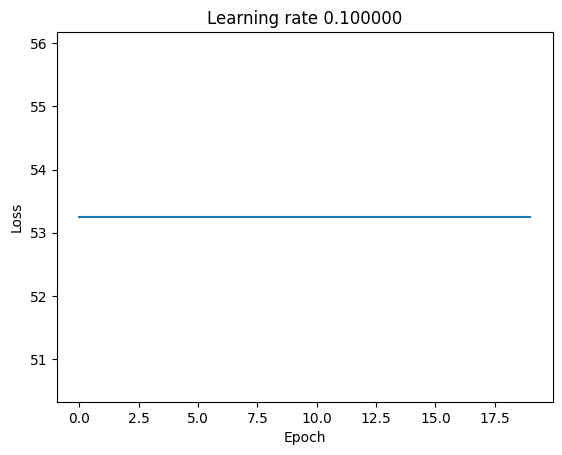

In [ ]:
hidden_dim = 512
lr = 0.1
epochs = 20
test_ratio = 10



data = []
with open("samples.csv", newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quotechar='"')
    data = list(csvreader)

random.shuffle(data)

labels = [[d[-1]] for d in data]
data = [d[:-1] for d in data]

split = int(len(data) // test_ratio)
test = np.array(data[:split])
test_labels = np.array(labels[:split])
data = np.array(data[split:])
labels = np.array(labels[split:])

input_dim = len(data[0])
output_dim = len(labels[0])

print("Data initialized")

model = NeuralNetwork(input_dim, hidden_dim, output_dim)

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr)

loss_values = []

for epoch in range(epochs):

    print("Epoch {:d} / {:d}".format(epoch+1, epochs), end='\r')

    train = Data(data, labels)
    train_loader = DataLoader(dataset=train, batch_size=64, shuffle=False)

    
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

    loss_values.append(loss.item())

print("")

plt.plot(loss_values)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Learning rate {:f}".format(lr))
plt.show()

torch.save(model.state_dict(), "model.pth")